# Linguistic Features

## Part-of-speech tagging 

After **tokenization**, spaCy can **parse** and **tag** a given Doc. This is where the statistical model comes in, which enables spaCy to make a prediction of which tag or label most likely applies in this context. 

A model consists of binary data and is produced by showing a system enough examples for it to make predictions that generalize across the language – for example, a word following “the” in English is most likely a noun.

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

In [51]:
import pandas as pd
 
cols = ("text", "lemma", "POS", "POS_explain", "tag","Dep","Shape","is_alpha", "stopword")
rows = []

for token in doc:
    row = [token.text, token.lemma_, token.pos_,spacy.explain(token.pos_), token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop]
    rows.append(row)
 
df = pd.DataFrame(rows, columns=cols)
 
df

,text,lemma,POS,POS_explain,tag,Dep,Shape,is_alpha,stopword
0,Apple,Apple,PROPN,proper noun,NNP,nsubj,Xxxxx,True,False
1,is,be,VERB,verb,VBZ,aux,xx,True,True
2,looking,look,VERB,verb,VBG,ROOT,xxxx,True,False
3,at,at,ADP,adposition,IN,prep,xx,True,True
4,buying,buy,VERB,verb,VBG,pcomp,xxxx,True,False
5,U.K.,U.K.,PROPN,proper noun,NNP,compound,X.X.,False,False
6,startup,startup,NOUN,noun,NN,dobj,xxxx,True,False
7,for,for,ADP,adposition,IN,prep,xxx,True,True
8,$,$,SYM,symbol,$,quantmod,$,False,False
9,1,1,NUM,numeral,CD,compound,d,False,False


In [52]:
from spacy import displacy

displacy.render(doc, style="dep")

### Rule-based morphology

**Inflectional morphology** is the process by which a root form of a word is modified by adding prefixes or suffixes that specify its grammatical function but do not changes its part-of-speech. We say that a lemma (root form) is inflected (modified/combined) with one or more morphological features to create a surface form. Here are some examples:
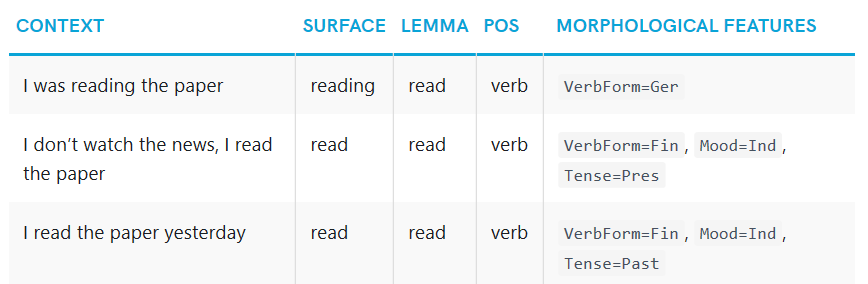

1. The tokenizer consults a mapping tableTOKENIZER_EXCEPTIONS, which allows sequences of characters to be mapped to multiple tokens. Each token may be assigned a part of speech and one or more morphological features.
2. The part-of-speech tagger then assigns each token an extended POS tag. In the API, these tags are known as Token.tag. They express the part-of-speech (e.g. VERB) and some amount of morphological information, e.g. that the verb is past tense.
3. For words whose POS is not set by a prior process, a mapping table TAG_MAP maps the tags to a part-of-speech and a set of morphological features.
4. Finally, a rule-based deterministic lemmatizer maps the surface form, to a lemma in light of the previously assigned extended part-of-speech and morphological information, without consulting the context of the token. The lemmatizer also accepts list-based exception files, acquired from WordNet.

## Dependency Parsing 

spaCy features a fast and accurate syntactic dependency parser, and has a rich API for navigating the tree. The parser also powers the sentence boundary detection, and lets you iterate over base noun phrases, or “chunks”. You can check whether a Docobject has been parsed with the doc.is_parsed attribute, which returns a boolean value. If this attribute is False, the default sentence iterator will raise an exception.

### Noun chunks

Noun chunks are “base noun phrases” – flat phrases that have a noun as their head. You can think of noun chunks as a noun plus the words describing the noun – for example, “the lavish green grass” or “the world’s largest tech fund”. To get the noun chunks in a document, simply iterate over Doc.noun_chunks

In [53]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

In [54]:
import pandas as pd
 
cols = ("text", "root_text", "root_dependency", "root_head_text")
rows = []

for chunk in doc.noun_chunks:
    row = [chunk.text, chunk.root.text, chunk.root.dep_, chunk.root.head.text]
    rows.append(row)
 
df = pd.DataFrame(rows, columns=cols)
df

,text,root_text,root_dependency,root_head_text
0,Autonomous cars,cars,nsubj,shift
1,insurance liability,liability,dobj,shift
2,manufacturers,manufacturers,pobj,toward


### Navigating the parse tree

spaCy uses the terms head and child to describe the words connected by a single arc in the dependency tree. The term dep is used for the arc label, which describes the type of syntactic relation that connects the child to the head. As with other attributes, the value of .dep is a hash value. You can get the string value with .dep_.

In [55]:
cols = ("text", "dep","dep_explain", "head_text", "head_pos", "child")
rows = []

for token in doc:
    row = [token.text, token.dep_,spacy.explain(token.dep_), token.head.text, token.head.pos_, [child for child in token.children]]
    rows.append(row)
 
df2 = pd.DataFrame(rows, columns=cols)
df2

,text,dep,dep_explain,head_text,head_pos,child
0,Autonomous,amod,adjectival modifier,cars,NOUN,[]
1,cars,nsubj,nominal subject,shift,VERB,[Autonomous]
2,shift,ROOT,None,shift,VERB,"[cars, liability]"
3,insurance,compound,None,liability,NOUN,[]
4,liability,dobj,direct object,shift,VERB,"[insurance, toward]"
5,toward,prep,prepositional modifier,liability,NOUN,[manufacturers]
6,manufacturers,pobj,object of preposition,toward,ADP,[]


In [56]:
from spacy import displacy
displacy.render(doc, style="dep")

Because the syntactic relations form a tree, every word has exactly one head. You can therefore iterate over the arcs in the tree by iterating over the words in the sentence. This is usually the best way to match an arc of interest — from below:

In [45]:
import spacy
from spacy.symbols import nsubj, VERB

nlp = spacy.load("en_core_web_sm")
doc = nlp("Autonomous cars shift insurance liability toward manufacturers")

# Finding a verb with a subject from below — good
verbs = set()
for possible_subject in doc:
    if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
        verbs.add(possible_subject.head)
print(verbs)

{shift}


In [58]:
# Finding a verb with a subject from above — less good
verbs = []
for possible_verb in doc:
    if possible_verb.pos == VERB:
        for possible_subject in possible_verb.children:
            if possible_subject.dep == nsubj:
                verbs.append(possible_verb)
                break
verbs

[shift]

To iterate through the children, use the token.children attribute, which provides a sequence of Token objects.

### Iterating around the local tree 

A few more convenience attributes are provided for iterating around the local tree from the token. **Token.lefts** and **Token.rights** attributes provide sequences of syntactic children that occur before and after the token. Both sequences are in sentence order. There are also two integer-typed attributes, Token.n_lefts and Token.n_rights that give the number of left and right children.

In [67]:
doc = nlp("bright red apples on the tree")
print([token.text for token in doc[2].lefts]) 
print([token.text for token in doc[2].rights])  
print(doc[1].n_lefts)  # 2
print(doc[3].n_rights)  # 1

['bright', 'red']
['on']
0
1
